In [1]:
import sys
sys.path.append("../")
import cirq
import numpy as np
import math
import utils.qsp.CoefficientFinder as cf
import utils.qsp.AngleAnalysis as aa
import utils.qsp.QSPStatePrep as qsp
import utils.qsp.StateCoeffAnalysis as sca
import matplotlib.pyplot as plt

# Test

Naive Degree: 282, Improved Degree: 40
This is the type of the working degree divided by 2: <class 'int'>
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 1.585e-01
iter: 002 --- err: 3.823e-02
iter: 003 --- err: 9.479e-03
iter: 004 --- err: 2.365e-03
iter: 005 --- err: 5.910e-04
iter: 006 --- err: 1.477e-04
iter: 007 --- err: 3.693e-05
iter: 008 --- err: 9.233e-06
iter: 009 --- err: 2.308e-06
iter: 010 --- err: 5.770e-07
iter: 011 --- err: 1.443e-07
iter: 012 --- err: 3.606e-08
iter: 013 --- err: 9.016e-09
iter: 014 --- err: 2.254e-09
iter: 015 --- err: 5.635e-10
iter: 016 --- err: 1.409e-10
iter: 017 --- err: 3.522e-11
iter: 018 --- err: 8.805e-12
iter: 019 --- err: 2.201e-12
iter: 020 --- err: 5.509e-13
[sym_qsp] Stop criteria satisfied.
QSP Angles: ([-0.7853981633974384, -1.570796326794765, -1.5707963267911758, -1.570796326784667, -1.5707963263398765, -1.5707963283415292, -1.5707962902544037, -1.5707965537335584, -1.5707942920174303, -1.57080812

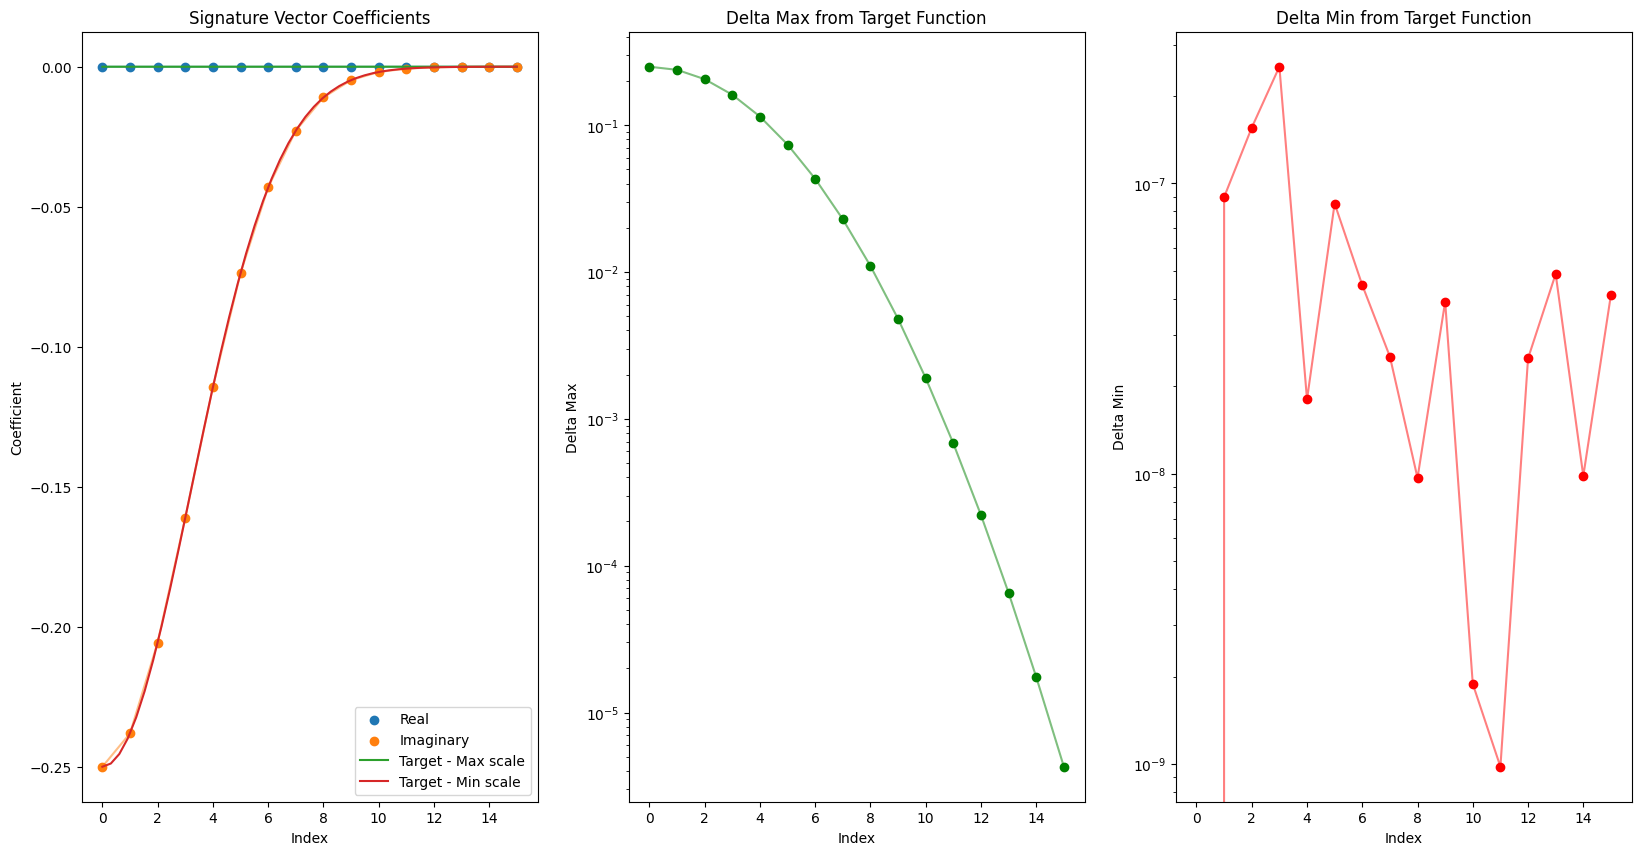

Done


In [5]:
# --- -- -- - - - Test Setup - - -- -- --- #
# Define the sigma and error values for testing
s, err, n = 0.2, 1e-6, 4

# # Initialise the TargetSeriesCoefficients class with the given sigma
X = cf.TargetSeriesCoefficients(sigma = s)

# # Estimate the degree
naive_degree, improved_degree = aa.AnalyticalDegreeFromError(s, err), aa.NumericalDegreeFromError(s, err, n)
print(f"Naive Degree: {naive_degree}, Improved Degree: {improved_degree}")

# # Get the QSP angles
qsp_angles = aa.GetQSPAngleListAdv(s, improved_degree, err, plot = False, verbose = False)
print(f"QSP Angles: {qsp_angles}")
print(f"Length of QSP Angles: {len(qsp_angles[0])}")

test_angle_list = qsp_angles[0]

# # Seems that we want to post select the signature bits '10'
arr = qsp.FullSVFromStatePrepCircuit(test_angle_list,n)

vec = arr[0]
coeff = sca.SignatureVectorElements(vec, [1,0], n)
sca.PlotSignatureVectorElements(coeff, n, s)

print("Done")

# QSP and AA

In [ ]:
class QSPStatePrepAA:

    def __init__(self, 
                 system_nqubits: int = 2,
                 sigma: float = 0.25,
                 error: float = 1e-6):
        
        self.system_nqubits = system_nqubits
        self.sigma = sigma
        self.error = error
        # Generate coefficients
        X = cf.TargetSeriesCoefficients(sigma = self.sigma)

        # # Estimate the degree
        improved_degree =  aa.NumericalDegreeFromError(self.sigma, self.error, self.system_nqubits)

        # # Get the QSP angles
        self.qsp_angles = aa.GetQSPAngleListAdv(self.sigma, improved_degree, self.error, plot = False, verbose = False)

        # Define Qubits
        self.qsp_anc, self.be_anc = cirq.NamedQubit('qsp_anc'), cirq.NamedQubit('rbe_anc')
        self.workspace = [cirq.NamedQubit(f'x_{i}') for i in range(1, self.system_nqubits + 1)]

    def qsp_circuit(self,):

        angle_list = self.qsp_angles[0]
        be_qbs = [self.be_anc] + self.workspace

        # Initialise circuit
        circuit = cirq.Circuit()
        circuit.append(cirq.H.on(self.qsp_anc))
        circuit.append(cirq.H.on_each(self.workspace))

        BE_gate = qsp.ControlledRySequenceGate(num_workspace_qubits=self.system_nqubits)

        for i in range(len(angle_list)-1,0,-1):
            print(angle_list[i])
            circuit.append(qsp.CRGate(phi=angle_list[i])(self.be_anc, self.qsp_anc))
            circuit.append(BE_gate(*be_qbs))
        # add zeroth angle
        circuit.append(qsp.CRGate(phi=angle_list[0])(self.be_anc, self.qsp_anc))

        circuit.append(cirq.H.on(self.qsp_anc))
       
        return circuit

    
    def phase_oracle(self, ) -> cirq.Circuit:
      """
      Negate the amplitude with |1>_qsp_acn |0>_be_anc
      """
      circ = cirq.Circuit()
      circ.append(cirq.X(self.be_anc))
      circ.append(cirq.H(self.be_anc)) 
      circ.append(cirq.XPowGate().controlled(1, control_values=[1]).on(self.qsp_anc, self.be_anc))
      circ.append(cirq.H(self.be_anc)) 
      circ.append(cirq.X(self.be_anc))
      return circ

    def zero_reflection(self, qubits: list) -> cirq.Circuit:
      """
      Reflect zero state.
      Implement I - 2|0><0| over all qubits
      """
      circ = cirq.Circuit()
      for i in range(len(qubits)):
        circ.append(cirq.X(qubits[i]))

      circ.append(cirq.H(qubits[-1])) # on be_anc
      circ.append(cirq.XPowGate().controlled(self.system_nqubits+1).on(*qubits))
      circ.append(cirq.H(qubits[-1])) # on be_anc

      for i in range(len(qubits)):
        circ.append(cirq.X(qubits[i]))

      return circ

    def amplitude_amplification(self, num_iteration: int) -> cirq.Circuit:
        circ = cirq.Circuit()

        phase_oracle = self.phase_oracle()
        good_state_preparation = self.qsp_circuit()
        reflection = self.zero_reflection(self.workspace+[self.qsp_anc]+[self.be_anc])

        circ.append(good_state_preparation, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
        for i in range(num_iteration):
            circ.append(phase_oracle, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
            circ.append(cirq.inverse(good_state_preparation), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
            circ.append(reflection, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
            circ.append(good_state_preparation, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

        return circ
    def construct_circuit(self,num_iteration: int) -> None:
        self.circuit = self.amplitude_amplification(num_iteration=num_iteration) 

    def get_output(self) -> list:
        # measurement
        # raw_sv = cirq.final_state_vector(self.circuit)
        # coeff = sca.SignatureVectorElements(raw_sv, [1,0], self.system_nqubits)
        # sca.PlotSignatureVectorElements(coeff, self.system_nqubits, self.sigma)
        self.circuit.append(cirq.measure(*(self.workspace[::-1]+[self.qsp_anc]+[self.be_anc]), key="result"))
        s = cirq.Simulator()
        samples = s.run(self.circuit, repetitions=1000)
        samples = cirq.ResultDict(records={'result': samples.records['result']})
        results = samples.histogram(key="result")
        # print(results)
        care_results = []

        for i in range(2**self.system_nqubits):
            binarized_i = format(i, "b").zfill(self.system_nqubits)
            
            #binarized_i = binarized_i[::-1]
            care_position = int(binarized_i+"10", 2)
            # care_position = i
            care_results.append(results[care_position])

        amplitude = np.sqrt(np.array(care_results)/(sum(care_results)))

        return amplitude

In [79]:
def generate_coeff(n: int, sigma: float) -> np.ndarray:
  """
  Compute a vector of 2**n coefficients of gaussian function
  """

  N = 2**n
  x = np.arange(N)
  x = (x) / (N)
  coeffs = np.exp(-(x**2/(2*sigma**2)))
  return coeffs

This is the type of the working degree divided by 2: <class 'int'>
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 1.585e-01
iter: 002 --- err: 3.823e-02
iter: 003 --- err: 9.479e-03
iter: 004 --- err: 2.365e-03
iter: 005 --- err: 5.910e-04
iter: 006 --- err: 1.477e-04
iter: 007 --- err: 3.693e-05
iter: 008 --- err: 9.233e-06
iter: 009 --- err: 2.308e-06
iter: 010 --- err: 5.770e-07
iter: 011 --- err: 1.443e-07
iter: 012 --- err: 3.606e-08
iter: 013 --- err: 9.016e-09
iter: 014 --- err: 2.254e-09
iter: 015 --- err: 5.635e-10
iter: 016 --- err: 1.409e-10
iter: 017 --- err: 3.522e-11
iter: 018 --- err: 8.805e-12
iter: 019 --- err: 2.202e-12
iter: 020 --- err: 5.506e-13
[sym_qsp] Stop criteria satisfied.
-0.7853981633981636
-1.5707963268174763
-1.570796327141852
-1.5707963302552466
-1.5707963519963737
-1.570796469770103
-1.5707969849926302
-1.5707988546969573
-1.570804572031801
-1.570821645098495
-1.5706573978425844
-1.5774449637850232
-1.488825346620

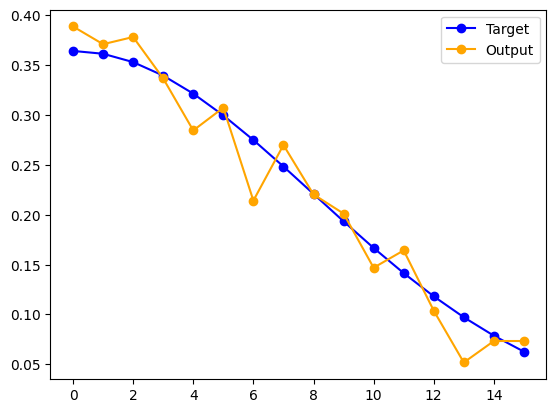

In [82]:
system_nqubits = 4
sigma = 0.5
y = generate_coeff(system_nqubits, sigma = sigma)
state_prep =  QSPStatePrepAA(system_nqubits=system_nqubits,sigma = sigma, error = 1e-6)
state_prep.construct_circuit(num_iteration = math.ceil((np.pi/4)*np.sqrt(2**system_nqubits)/np.linalg.norm(y)))

amplitudes = state_prep.get_output()
plt.plot(np.arange(0,2**system_nqubits), y/np.linalg.norm(y), 'o-', color='blue', label = 'Target')
plt.plot(np.arange(0,2**system_nqubits), amplitudes, 'o-', color='orange', label='Output')
plt.legend()